In [2]:
import yfinance as yf
import pandas as pd

In [3]:
tickerData = yf.Ticker("VZ")

tickerDf = tickerData.history(period='3y', interval='1d')

tickerClose = tickerDf.Close

daily_returns_nan = tickerClose.pct_change()
daily_returns = daily_returns_nan.dropna()

n = len(daily_returns)

print(daily_returns)
print(len(daily_returns))

Date
2021-05-04 00:00:00-04:00    0.011740
2021-05-05 00:00:00-04:00    0.001536
2021-05-06 00:00:00-04:00    0.010223
2021-05-07 00:00:00-04:00   -0.009614
2021-05-10 00:00:00-04:00    0.013624
                               ...   
2024-04-25 00:00:00-04:00   -0.006837
2024-04-26 00:00:00-04:00    0.011729
2024-04-29 00:00:00-04:00    0.010333
2024-04-30 00:00:00-04:00   -0.014966
2024-05-01 00:00:00-04:00   -0.007344
Name: Close, Length: 754, dtype: float64
754


In [4]:
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns.index = (daily_returns.index - daily_returns.index[0]).days

min_day = daily_returns.index.min()
max_day = daily_returns.index.max()

print(daily_returns)
normalized_index = (daily_returns.index - min_day) / (max_day - min_day)

daily_returns.index = normalized_index

daily_returns

Date
0       0.011740
1       0.001536
2       0.010223
3      -0.009614
6       0.013624
          ...   
1087   -0.006837
1088    0.011729
1091    0.010333
1092   -0.014966
1093   -0.007344
Name: Close, Length: 754, dtype: float64


Date
0.000000    0.011740
0.000915    0.001536
0.001830    0.010223
0.002745   -0.009614
0.005489    0.013624
              ...   
0.994511   -0.006837
0.995425    0.011729
0.998170    0.010333
0.999085   -0.014966
1.000000   -0.007344
Name: Close, Length: 754, dtype: float64

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns

[Text(0.5, 1.0, 'y train-test split '), Text(0.5, 0, 't'), Text(0, 0.5, '')]

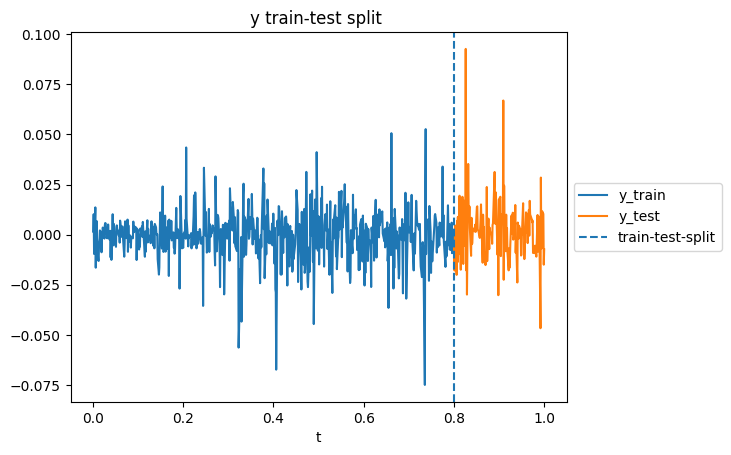

In [64]:
x = daily_returns.index.values.T
y = daily_returns.values.T

prop_train = 0.8
n_train = round(prop_train * n)

x_train = x[1:n_train]
y_train = y[1:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='')

In [167]:
with pm.Model() as ts_model:
    l = pm.HalfNormal('l', (3/2)**(1/250)-1)

    M = pm.gp.mean.Zero()
    K = pm.gp.cov.Matern32(1, l)

    err = pm.HalfNormal('err', 0.1)
    xuu = pm.gp.util.kmeans_inducing_points(40, x_train.reshape(-1,1))

    gp_comp = pm.gp.MarginalApprox(mean_func=M, cov_func=K)
    gp_comp.marginal_likelihood('target', X=x_train.reshape(-1,1), y=y_train, Xu=xuu, noise=err)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [44]:
(3/2)**(1/250)-1

0.0016231763593843596

In [168]:
with ts_model:
  trace = pm.sample()

In [169]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l,0.046,0.001,0.044,0.048,0.0,0.0,589.0,737.0,1.0
err,0.108,0.005,0.099,0.117,0.0,0.0,622.0,722.0,1.0


array([[<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'err'}>, <Axes: title={'center': 'err'}>]],
      dtype=object)

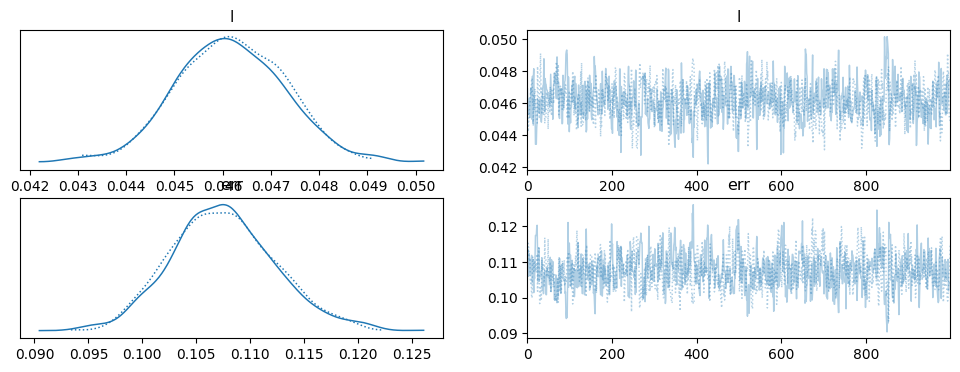

In [170]:
az.plot_trace(trace)

In [171]:
with ts_model:
    x_test_con = gp_comp.conditional('x_test_con', x_test.reshape(-1,1))
    pred = pm.sample_posterior_predictive(trace, var_names=["x_test_con"])

<ipython-input-171-28a65d8c351e>:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred = pm.sample_posterior_predictive(trace, var_names=["x_test_con"])


<Axes: >

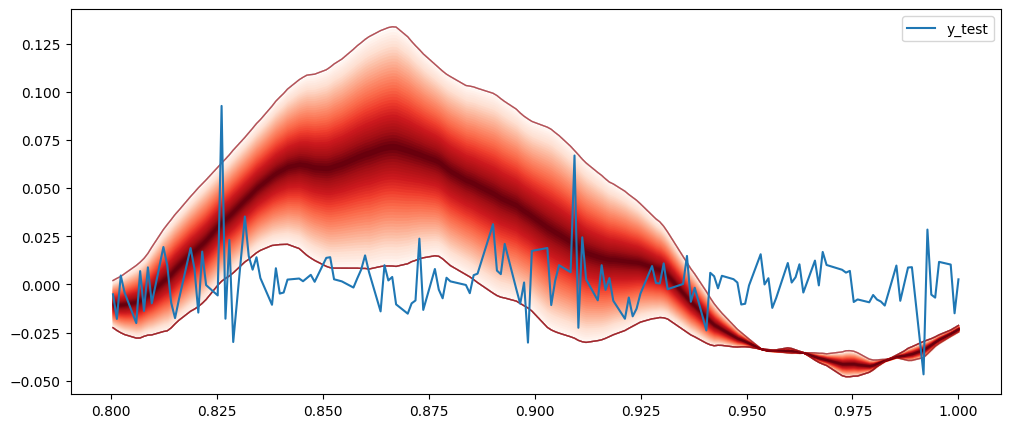

In [172]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, pred.posterior_predictive["x_test_con"].values.mean(axis=1), x_test);

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

In [172]:
daily_ret_annual = 2**(1/250)-1

with pm.Model() as ts_model_l:
    ret = pm.Normal("ret",0,daily_ret_annual)
    std = pm.Normal("std", pm.math.log(daily_ret_annual), 0.05)

    l = pm.Gamma('l', 1, 2)
    s = pm.Exponential('s', 100)

    M = pm.gp.mean.Zero()

    w_err = pm.HalfNormal("w",1)
    K = s * pm.gp.cov.Matern32(1, l)

    gp_comp = pm.gp.HSGP(mean_func=M, cov_func=K, m=[400], c=4)

    delta_std = gp_comp.prior("delta", X=x_train.reshape(-1,1))
    dd = pm.Deterministic("dd",delta_std)
    d = pm.Deterministic("d",pm.math.exp(std+delta_std))

    likelihood = pm.Normal("likelihood", ret, d, observed=y_train)

In [ ]:
ts_model_l.dd.eval()

In [173]:
with ts_model_l:
  trace_l = pm.find_MAP()

In [ ]:
trace_l

In [174]:
with ts_model_l:
    x_test_con_l = gp_comp.conditional('x_test_con', x_test.reshape(-1,1))
    pred_l = pm.sample_posterior_predictive([trace_l], var_names=["x_test_con"])

In [ ]:
preds = pred_l.posterior_predictive["x_test_con"].values
preds[0][0]

<Axes: >

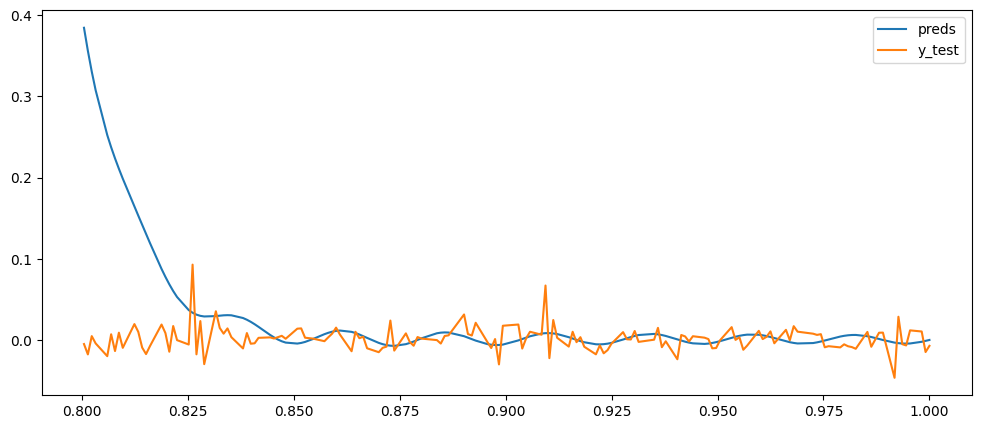

In [175]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

sns.lineplot(x=x_test.flatten(),y=preds[0][0], label='preds',ax=ax)

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

In [21]:
with pm.Model() as model:
    # Tendencia de curto prazo
    η_med = pm.HalfCauchy("η_med",0.5)
    ℓ_med = pm.HalfNormal("ℓ_med", 1)
    α = pm.HalfNormal("α", 1)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # Tendencia de longo prazo
    η_trend = pm.HalfCauchy("η_trend", 1)
    ℓ_trend = pm.HalfNormal("ℓ_trend", 4)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # Ruidos
    η_noise = pm.HalfNormal("η_noise", 0.5)
    ℓ_noise = pm.HalfNormal("ℓ_noise", 1)

    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise)
    gp_noise = pm.gp.Marginal(cov_func=cov_noise)

    # Soma dos GP
    gp = gp_medium + gp_trend + gp_noise

    σ_err = pm.HalfNormal("σ_noise", sigma=0.3)
    cov_err = pm.gp.cov.WhiteNoise(σ_err)

    y = gp.marginal_likelihood("y", X=x_train.reshape(-1,1), y=y_train,sigma=cov_err)


In [22]:
with model:
  trace_c = pm.find_MAP()

In [23]:
with model:
    x_test_con_l = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive([trace_c], var_names=["x_test"])

In [28]:
pred_m.posterior_predictive["x_test"].values[0][0]

array([ 1.99132962e-03, -1.31211926e-04, -2.61870939e-04,  3.37947508e-05,
        1.93720895e-03,  6.27743722e-05,  3.58769570e-04, -1.61229737e-03,
       -7.46123596e-04, -6.63154409e-04, -7.46798958e-04,  3.74737185e-05,
        7.72363875e-04, -9.51597562e-04, -4.53754980e-05, -2.65175648e-03,
       -8.57374373e-04,  5.41099832e-04, -1.68345657e-04, -6.94494306e-04,
        1.88006628e-03, -4.41917387e-04, -1.36567888e-03,  6.08451814e-04,
        1.40168214e-05, -6.02506516e-05, -9.96617622e-04, -8.13531826e-04,
       -6.75637729e-04, -9.09463629e-04, -1.11808411e-04, -9.51684931e-04,
        8.05349638e-04, -1.41172333e-03,  4.57959934e-04, -9.83681967e-04,
       -1.44383955e-03, -6.28568784e-04,  1.88049903e-06, -7.48474428e-04,
       -4.27835904e-04, -3.93813157e-04, -2.45591199e-04, -6.61869746e-04,
        4.19242429e-04,  1.13945266e-03, -1.02747393e-04, -1.19183923e-03,
        4.91535570e-04, -6.08904663e-04, -3.48033324e-04,  3.61343005e-05,
       -5.86015021e-04,  

<Axes: >

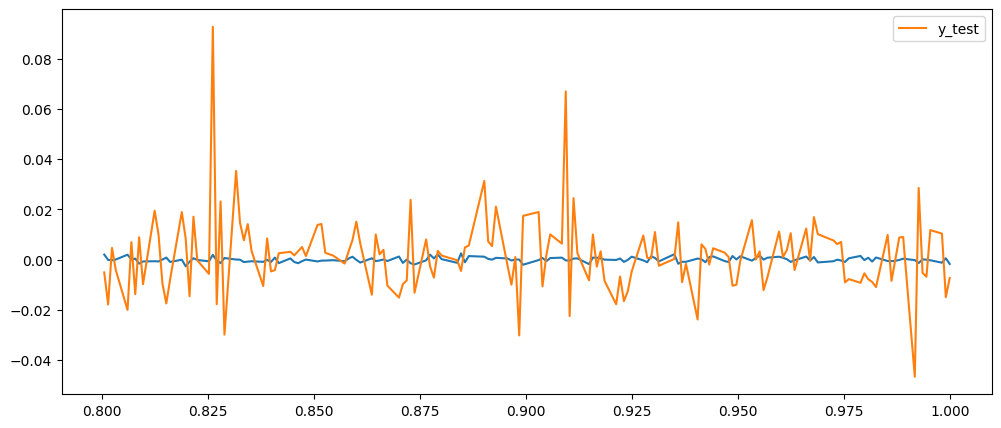

In [31]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

sns.lineplot(ax=ax, x=x_test.flatten(),y=pred_m.posterior_predictive["x_test"].values[0][0])

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

# Exercícios

1) Implemente um modelo com os parâmetros de escala ajustados para outro ticker da NYSE.